# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [6]:
%pylab inline
import gzip
import _pickle as cPickle
#import cPickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [9]:
# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f, encoding='latin')

#mnist_dim = (28, 28)
# print "MNIST data loaded;", " number of samples:", len(mnist_labels), \ 
#      '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

In [10]:
# From ML1 lab 2, as discussed it's okay to use it
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, (i+1))
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()

In [11]:
binary = np.zeros(mnist_images.shape)
for i in range(mnist_images.shape[0]):
    v = mnist_images[i,:] > .5
    binary[i,:] = [int(n) for n in v]


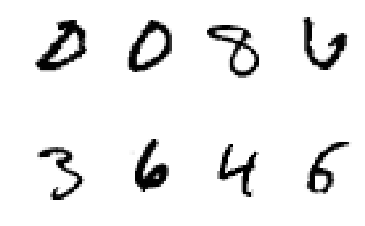

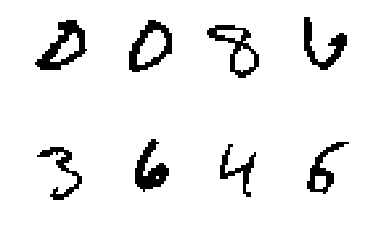

In [12]:
plot_digits(mnist_images[0:8],4)
plot_digits(binary[0:8],4)


### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [13]:
def P_xn_muk ( x, mu_par, n):
    return np.prod ( ((mu_par ** x[n] ) * (1 - mu_par) ** (1-  x[n]) ) , 1) 

In [14]:
def logL (x, mu_par, pi_par):
    S = 0
    for n in range(x.shape[0]):
        S = S + np.log (sum (pi_par * P_xn_muk ( x = x, mu_par = mu_par, n=n )) )
    return S

In [15]:
def up_gamma (x, mu_par, pi_par):
    n = x.shape[0]
    k = mu_par.shape[0]
    gamma = np.zeros([n,k])
    for i in range(n):
        p = P_xn_muk(x = x , mu_par = mu_par, n = i)
        gamma_n = p * pi_par / sum(p * pi_par)
        gamma[i,:]= gamma_n
    return gamma

In [16]:
def up_pi (gamma_znk_par):
    N_k = np.sum(gamma_znk_par,0)
    N   = sum(N_k)
    return N_k / N, N_k

In [17]:
def up_muk (x, N_k_par, gamma_par):
    return np.matrix.transpose(1/N_k_par * (np.dot (np.matrix.transpose(x) , gamma_par)))

In [18]:
def EM(batch, K, max_iter):
    x = batch
    #Initialize
    threshold = 0.000001 # maximum LL change for convergence
    D       = x.shape[1]
    mu      = np.random.uniform(.4,.6, size =  K*D ).reshape(K,D)
    pis      = 1/K * np.ones( K )
    # Calculate starting LL
    LL      = logL(x = x, mu_par = mu, pi_par = pis)
    # Start iterative EM optimization
    i       = 0
    epsilon = 1
    while( epsilon > threshold and max_iter > i):
        i   = i+1
        # E-step
        gamma_znk = up_gamma(x = x, mu_par = mu, pi_par = pis)
        # M-step
        pis, N_k   = up_pi(gamma_znk_par = gamma_znk)
        mu        = up_muk(x = x, N_k_par = N_k, gamma_par = gamma_znk)
        # Re-evaluate 
        LL_old    = LL
        LL        = logL(x = x, mu_par = mu, pi_par = pis)
        epsilon   = np.absolute(LL - LL_old)
        if( (i / 10).is_integer() ):
            print("Run ", i, "; Log-likelihood is ", LL)          
                         
    return pis, mu, gamma_znk, LL, i
    


### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

In [19]:
digitlist = np.array([i==2 or i==3 or i==4 for i in mnist_labels])
subset_binary = binary[digitlist]
subset_labels = mnist_labels[digitlist]

Run  10 ; Log-likelihood is  -182087.037716
Run  20 ; Log-likelihood is  -182084.353443
Run  30 ; Log-likelihood is  -182066.86655


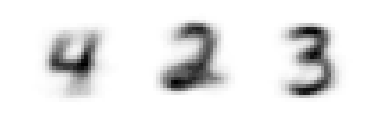

In [23]:
n = 1000
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=False)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]
pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = 3, max_iter = 1000)
plot_digits(mu_out, numcols=3)

In [24]:
true_pi = np.array([sum(sample_subset_labels == 2), sum(sample_subset_labels == 3), sum(sample_subset_labels  == 4)])/ sample_subset_labels.shape[0]

In [25]:
print("Estimated mixing coefficients: ", np.round(pi_out,3))
print("True mixing coefficients: ", np.round(true_pi,3))

Estimated mixing coefficients:  [ 0.393  0.293  0.314]
True mixing coefficients:  [ 0.342  0.321  0.337]


**Answer** On most runs, the mixing coefficients are roughly the same, each taking up about 1/3 of the sample. However, depending on the random set of samples (and its size) the Bernoulli Mixture Model sometimes can have larger  numbers of mis-classified samples leading to some $\pi_k$ close to .50 or .20 and further away from the true coefficients.

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

**1.3.1: Optimizing over increasing number of classes K**

** Answer ** Increasing the number of classes $K$ generally increases the flexibility of the model, and thus increases the maximum log likelihood (see Figure below). One may choose a number of classes $K$ beyond which the log-likelihood does not increase "steeply" anymore. In the experiment below, interestingly, the normatively "correct" number of classes ($K=3$) is certainly not at a point where $K$ does not increase steeply anymore. The graph shows that the best choice of number of classes may be rather 6, as afterwards the log-likelihood increases less steeply. This finding reflects that allowing for an additional class still allows the model to accomodate an additional new writing style at these numbers, but not many more distinct styles are expectable beyond these (although the log-likelihood will continue to increase).

To understand the writing styles in more detail, one may look at the plots of the coefficients for different $K$ (see also below). We see that for $K>2$ the three numbers are always identified and that for higher numbers slightly different varieties in writing style are learnt. For example, the number 2 can be written with a curved ending or straight. Also the lower part of the three shows differences and the vertical alignment of the 4 can be slightly sloped or straight.




In [26]:
n = 2000
K_max = 10
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=True)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]

pis = []
mus = []
LLs = []
for i in range(2,K_max+1) :
    pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = i, max_iter = 1000)
    pis.append(pi_out)
    mus.append(mu_out)
    LLs.append(LL_out)

Run  10 ; Log-likelihood is  -385192.914336
Run  20 ; Log-likelihood is  -384992.95921
Run  30 ; Log-likelihood is  -384991.005798
Run  40 ; Log-likelihood is  -384990.863008
Run  50 ; Log-likelihood is  -384990.860482
Run  10 ; Log-likelihood is  -367872.425469
Run  20 ; Log-likelihood is  -367841.214127
Run  30 ; Log-likelihood is  -367841.117722
Run  40 ; Log-likelihood is  -367841.095743
Run  50 ; Log-likelihood is  -367840.841764
Run  60 ; Log-likelihood is  -367840.807569
Run  10 ; Log-likelihood is  -358497.307137
Run  20 ; Log-likelihood is  -358403.139501
Run  30 ; Log-likelihood is  -358367.919725
Run  40 ; Log-likelihood is  -358365.115657
Run  10 ; Log-likelihood is  -353759.7412
Run  20 ; Log-likelihood is  -352594.120642
Run  30 ; Log-likelihood is  -352508.191729
Run  40 ; Log-likelihood is  -352432.852976
Run  50 ; Log-likelihood is  -352431.123936
Run  10 ; Log-likelihood is  -346378.16393
Run  20 ; Log-likelihood is  -344834.252454
Run  30 ; Log-likelihood is  -344664

<function matplotlib.pyplot.show>

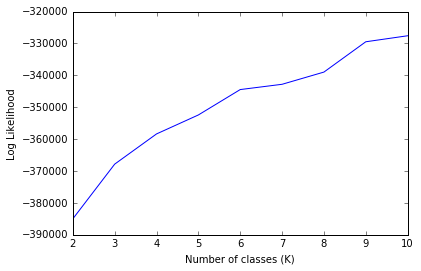

In [27]:
plt.plot( np.arange(2,K_max+1), LLs)
plt.ylabel('Log Likelihood')
plt.xlabel('Number of classes (K)')
plt.show

K = 2


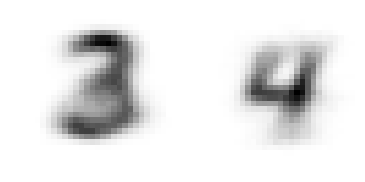

K = 3


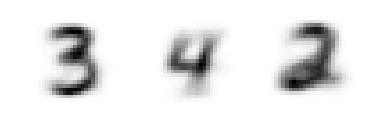

K = 4


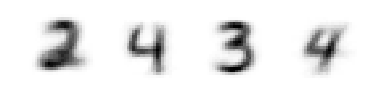

K = 5


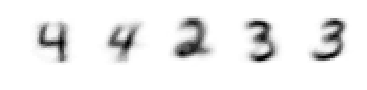

K = 6


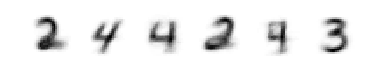

K = 7


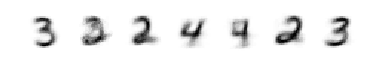

K = 10


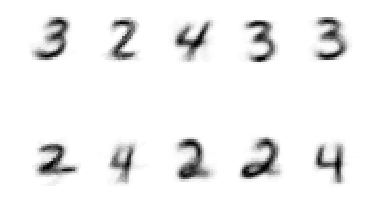

In [28]:
print("K = 2")
plot_digits(mus[0], numcols=2)
print("K = 3")
plot_digits(mus[1], numcols=3)
print("K = 4")
plot_digits(mus[2], numcols=4)
print("K = 5")
plot_digits(mus[3], numcols=5)
print("K = 6")
plot_digits(mus[4], numcols=6)
print("K = 7")
plot_digits(mus[5], numcols=7)
print("K = 10")
plot_digits(mus[8], numcols=5)

**1.3.2: Visualizing and interpreting misclassified digits **

**Answer:** Below we manually code the numbers into learnt classes (K=3) and then select and plot an example set of misclassified digits. The misclassified numbers are those that are written in a very unusual / ambiguous way. For example, some numbers are squashed together to the center and are even for humans difficult to identify. 

Run  10 ; Log-likelihood is  -182602.35613
Run  20 ; Log-likelihood is  -182598.276126
Run  30 ; Log-likelihood is  -182556.639346
Run  40 ; Log-likelihood is  -182556.204979


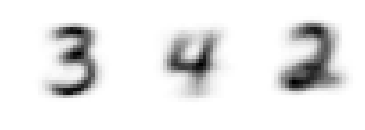

In [29]:
n = 1000
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=False)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]
pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = 3, max_iter = 1000)
plot_digits(mu_out, numcols=3)

Misclassification rate  0.105
True labels  [3 3 2 3 2 2 3 3 3 3]


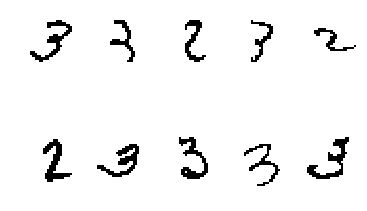

Assigned labels  [ 2.  4.  3.  4.  4.  3.  2.  2.  4.  2.]


In [31]:
max_z = np.argmax(gamma_out,1) 
# Has to be coded manually depending on outcome of EM
def mapping(i):
    if i == 0:
        return 3
    elif i == 1:
        return 4
    elif i == 2:
        return 2
    return i

rec_max_z = np.zeros(n)
for i in range(n):
    rec_max_z[i] = mapping(max_z[i])
    
mis_clas = rec_max_z != sample_subset_labels
print("Misclassification rate ", sum(mis_clas)/n) #misclssification rate

print("True labels ", sample_subset_labels[mis_clas == 1][0:10])
plot_digits(sample_subset_binary[mis_clas == 1][0:10],5)
print("Assigned labels ", rec_max_z[mis_clas == 1][0:10])

** 1.3.3: Initializing mixing coefficients at true values **

** Answer: ** We modified the EM function by allowing for initialization of pi (EM_ini). The standard EM function from above uses a 1/K initialization for all mixture coefficients pi, i.e. equal probability of class membership. For our experiment in the EM_ini function we set pi now equal to the observed sample proportions of the label categories (true_pi). We ran this experiment both with a small sample size (n=300) or a large one (n=3000). The results shown below are for the n=3000 run (we draw samples with replacement here). We find that the log-likelihood and misclassification rates for the two types of initializations are very similar, sometimes the one dominating the other. We notice that in some runs the 1/K can yield outliers with high misclassification rates whereas the true pi initialization is more consistent (arround .10 to .16 misclassified numbers). These results hold for both the high and the low number of samples and show that our initial standard initialization already works very well, probably because in this application the 1/K proportions are very close to the true proportions (see true pi print below). On average, however, we believe the true pi initilization works better, as in the example shown below.

In [36]:
def EM_ini(batch, K, max_iter, pis):
    x = batch
    #Initialize
    threshold = 0.000001 # maximum LL change for convergence
    D       = x.shape[1]
    mu      = np.random.uniform(.4,.6, size =  K*D ).reshape(K,D)
    
    # Calculate starting LL
    LL      = logL(x = x, mu_par = mu, pi_par = pis)
    # Start iterative EM optimization
    i       = 0
    epsilon = 1
    while( epsilon > threshold and max_iter > i):
        i   = i+1
        # E-step
        gamma_znk = up_gamma(x = x, mu_par = mu, pi_par = pis)
        # M-step
        pis, N_k   = up_pi(gamma_znk_par = gamma_znk)
        mu        = up_muk(x = x, N_k_par = N_k, gamma_par = gamma_znk)
        # Re-evaluate 
        LL_old    = LL
        LL        = logL(x = x, mu_par = mu, pi_par = pis)
        epsilon   = np.absolute(LL - LL_old)
        if( (i / 10).is_integer() ):
            print("Run ", i, "; Log-likelihood is ", LL)          
                         
    return pis, mu, gamma_znk, LL, i
  

In [37]:
n = 3000
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=True)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]
true_pi = np.array([sum(sample_subset_labels == 2), sum(sample_subset_labels == 3), sum(sample_subset_labels  == 4)])/ sample_subset_labels.shape[0]

pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = 3, max_iter = 1000)
pi_out_ini, mu_out_ini, gamma_out_ini, LL_out_ini, iterations_ini = EM_ini(batch = sample_subset_binary, K = 3, max_iter = 1000, pis = true_pi)


Run  10 ; Log-likelihood is  -566945.558067
Run  20 ; Log-likelihood is  -559444.886566
Run  30 ; Log-likelihood is  -557778.235911
Run  40 ; Log-likelihood is  -557621.302165
Run  50 ; Log-likelihood is  -557611.318919
Run  10 ; Log-likelihood is  -555247.904404
Run  20 ; Log-likelihood is  -551823.831895
Run  30 ; Log-likelihood is  -551772.558924
Run  40 ; Log-likelihood is  -551759.434618
Run  50 ; Log-likelihood is  -551751.66461
Run  60 ; Log-likelihood is  -551751.645385
Run  70 ; Log-likelihood is  -551620.529384
Run  80 ; Log-likelihood is  -551588.355994


In [42]:
print("True mixture proportions: ", true_pi)
print("Log-likelihood with 1/K initialization: ", LL_out)
print("Log-likelihood with true pi initialization: ", LL_out_ini)

True mixture proportions:  [ 0.33766667  0.315       0.34733333]
Log-likelihood with 1/K initialization:  -557609.861508
Log-likelihood with true pi initialization:  -551588.135943


With 1/K initialization


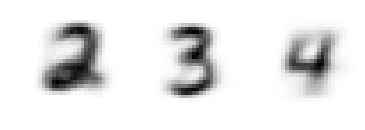

With true pi initialization


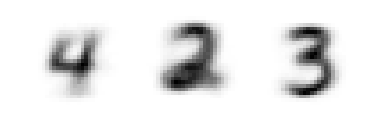

In [39]:
print("With 1/K initialization")
plot_digits(mu_out, numcols=3)
print("With true pi initialization")
plot_digits(mu_out_ini, numcols=3)
#
max_z = np.argmax(gamma_out,1) 
max_z_ini = np.argmax(gamma_out_ini,1) 

In [40]:
# Has to be coded manually depending on outcome of EM
def mapping(i):
    if i == 0:
        return 2
    elif i == 1:
        return 3
    elif i == 2:
        return 4
    return i

rec_max_z = np.zeros(n)
for i in range(n):
    rec_max_z[i] = mapping(max_z[i])

# Has to be coded manually depending on outcome of EM
def mapping(i):
    if i == 0:
        return 4
    elif i == 1:
        return 2
    elif i == 2:
        return 3
    return i

rec_max_z_ini = np.zeros(n)
for i in range(n):
    rec_max_z_ini[i] = mapping(max_z_ini[i])


In [41]:
mis_clas = rec_max_z != sample_subset_labels
mis_clas_ini = rec_max_z_ini != sample_subset_labels
print ("Misclassification with 1/K initialization: ", sum(mis_clas)/n, )  #misclssification rates
print ("Misclassification with true pi initialization: ", sum(mis_clas_ini)/n, )  #misclssification rates

Misclassification with 1/K initialization:  0.191666666667
Misclassification with true pi initialization:  0.118


### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

** Answer: ** In variational inference, which means a full Bayesian treatment of the Bernoulli Mixture model, the parmeters $\mu$ and $\pi$, which are assumed to be deterministic in the maximum likelihood approach, receive prior distirbutions. The most useful are conjugate priors. As $\mu$ are the parameters of a (multivariate) Bernoulli distribution, the conjugate prior is the beta distribution. The prior for the mixture parameters $\pi$ is usefully chosen as the Dirichlet distribution, which is the conjugate prior to a multinomial distribution.



## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


** Answer: ** The function $q(\theta)$ approximates $p(\theta|\bx)$. Actually, it is not directly visible from the function given. Rather we first have to extend it a bit like:

$\ln p(\bx) = \mathcal{L}(q(\theta)) + \mathrm{KL} \big(q(\theta)||p(\theta|\bx) \big)$

where

$\mathcal{L}(q(\theta)) = \int q(\theta) \ln \frac{p(\theta | \bx) p(\bx) }{q(\theta)} d\theta$ 

Proof: 

$\mathcal{L}(q(\theta)) + \mathrm{KL} \big(q(\theta)||p(\theta|\bx) \big) = \int q(\theta) \ln \frac{p(\theta | \bx) p(\bx) }{q(\theta)}  d\theta + \int q(\theta) \ln \frac{q(\theta)}{p(\theta|x)} d\theta= \int q(\theta) \big[ \ln p(\theta | \bx) p(\bx) - \ln q(\theta) + \ln q(\theta) - \ln p(\theta|\bx) \big] d\theta = \ln p(\bx) \int q(\theta) d\theta = \ln p(\bx) $

As $\mathrm{KL} \big(q(\theta)||p(\theta|\bx) \big) \ge 0$ it can be seen that $p(\bx) =  \mathcal{L}(q(\theta))$ if and only if the equality holds and else $p(\bx) \ge  \mathcal{L}(q(\theta))$, so that $ \mathcal{L}(q(\theta))$ is a lower bound. By changing $q(\theta)$ we may move the lower bound closer to $\ln p(\bx)$ but only if the approximation is "exact", the equality holds. Using $q(\theta)$ is necessary when no closed form expressions for $p(\theta|\bx)$ exist so that the integral 

$p(\bx) = \int p(\theta|\bx) p(\bx) d\theta$

cannot be easily evaluated. Obviously $p(\theta|\bx)$ is also relevant in its own right as it gives the posterior probability of the latent variable and parameters. 

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence. Run the 

In [67]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## Set number of samples and number of X variables
N_samples, X_dim = mnist_images.shape 
## Mini batch size
mb_size = 64
## Fix dimensionality of latent variables (output layer)
Z_dim = 100 
## Dimensionality of the hidden layer
h_dim = 128 
## Learning rate for stochastic gradient descent
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## Initialize parameters of the encoder
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## Encoder neural network, Q(Z|X)=N(z|mu,sigma) function
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

## Sample from Z after applying reparameterization trick
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

## Initialize parameter of the decoder
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## Decoder neural network
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## Initilization for the run and run (controller) function
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)
losses = [10**10]


def run(num_iter,conv_check):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## Forward propagate through network
        ## Encode X using Q network, sample using reparameterization trick, decode sample Z with P network
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)
        X_sample = P(z)

        ## Compute Loss of decoding, cross entropy between decoded data and input data
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## Compute KL divergence between Q(Z|X)= N(z|mu,sig) and P(Z) = N(0,1)
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        
        ## Compute total loss and evaluate convergence
        loss = recon_loss + kl_loss
        #print(loss.data.numpy()[0])
        losses.append(loss.data.numpy()[0])
        if abs(losses[-1] - losses[-2]) < conv_check:
            break
        
        ## Backpropagation error towards input layer (and afterwards update weights in solver.step)
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()
        if(iter % 200 == 0):
            samples         = [sample_z(z_mu,z_var) for n in range(5)]
            decoded_samples_batch = [P(sam) for sam in samples] 
            print ('iteration: ', iter)
            plot_sam =decoded_samples_batch[0][0:4]
            plot_sam2 = plot_sam.data.numpy()
            
            plot_digits(plot_sam2,2)
        
        ## Now weights are updated for the mini batch and a new mini batch is chosen for num_iter
    return losses

('iteration: ', 0)


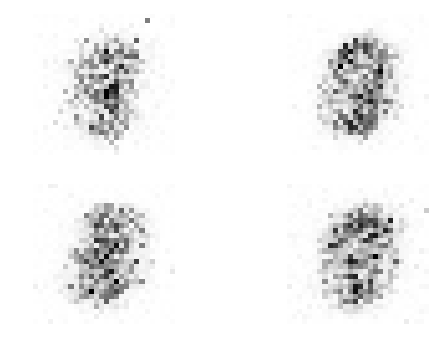

('iteration: ', 200)


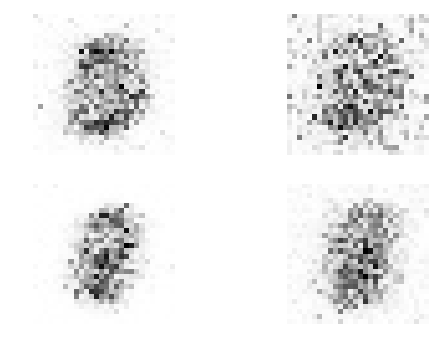

('iteration: ', 400)


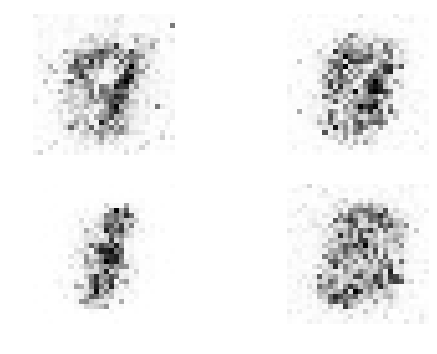

('iteration: ', 600)


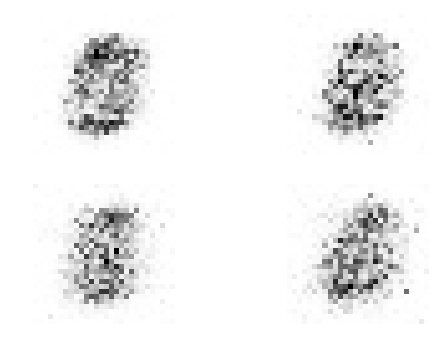

('iteration: ', 800)


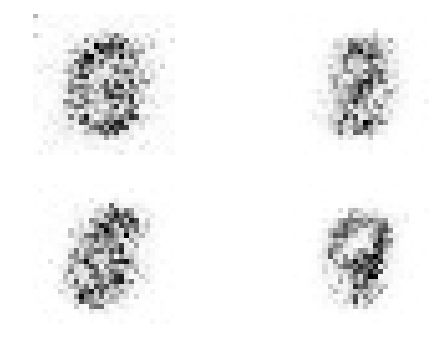

('iteration: ', 1000)


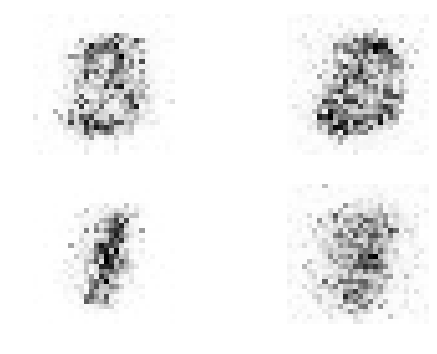

('iteration: ', 1200)


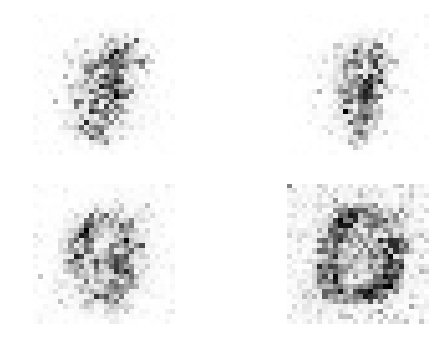

('iteration: ', 1400)


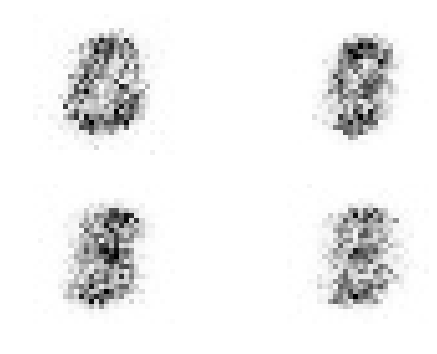

('iteration: ', 1600)


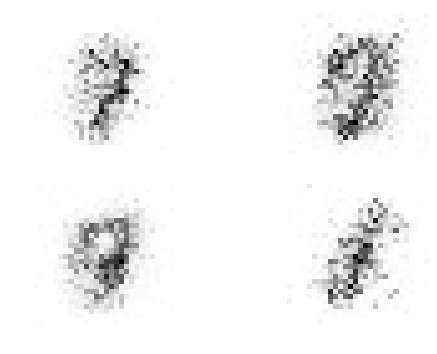

('iteration: ', 1800)


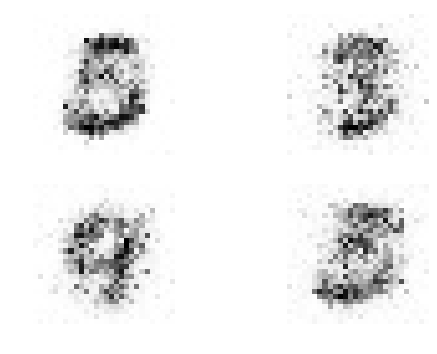

('iteration: ', 2000)


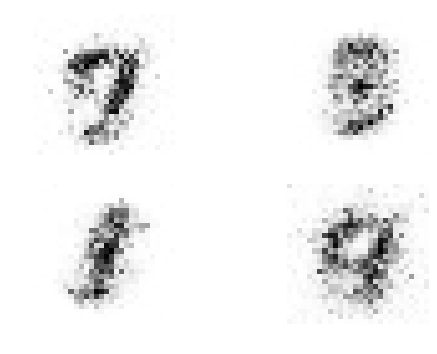

('iteration: ', 2200)


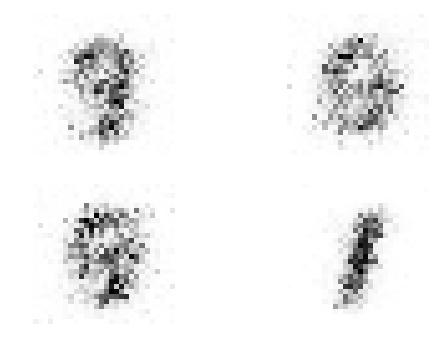

('iteration: ', 2400)


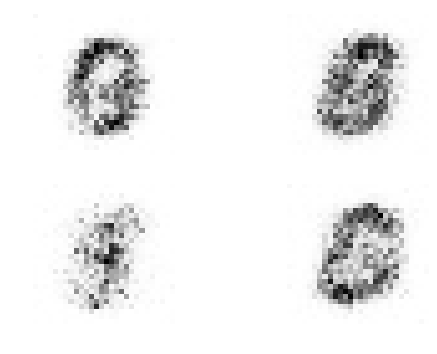

('iteration: ', 2600)


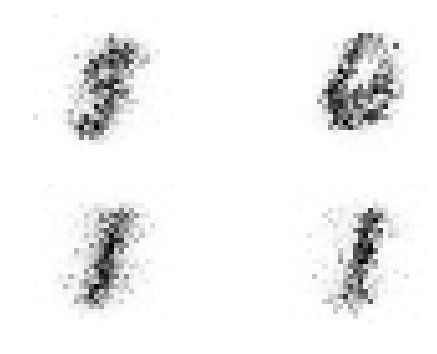

('iteration: ', 2800)


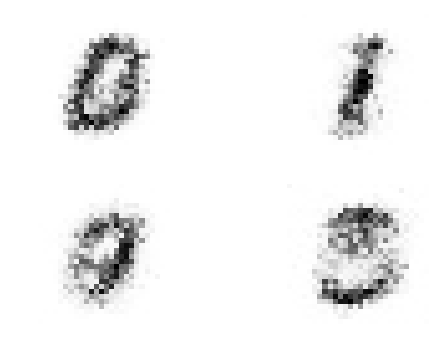

('iteration: ', 3000)


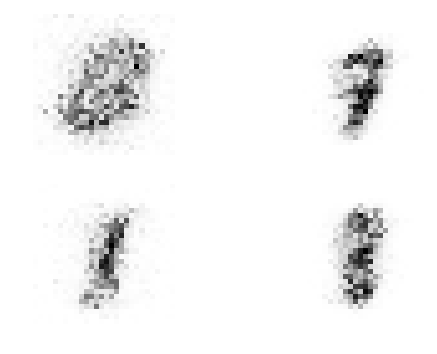

('iteration: ', 3200)


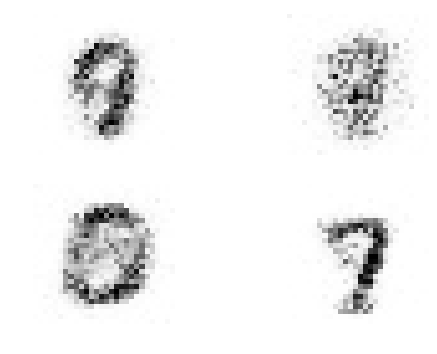

('iteration: ', 3400)


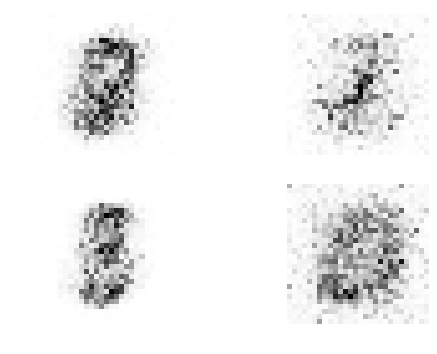

('iteration: ', 3600)


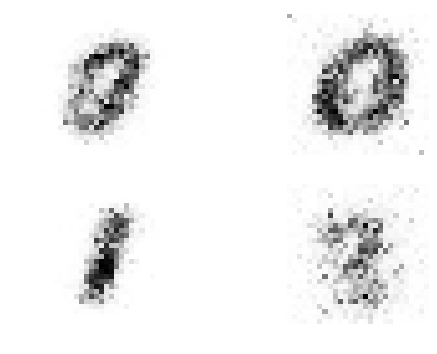

('iteration: ', 3800)


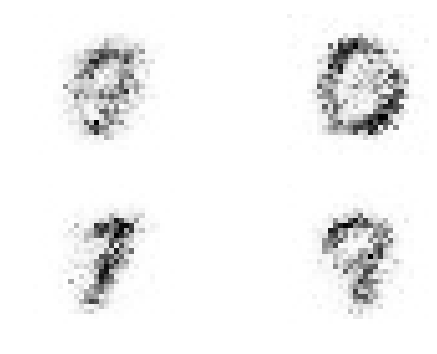

('iteration: ', 4000)


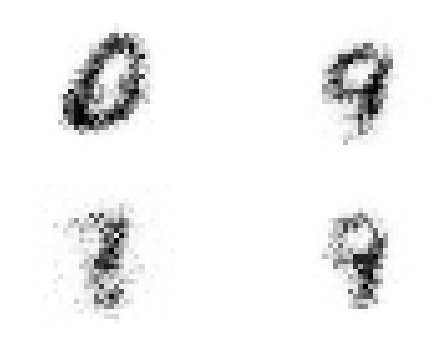

('iteration: ', 4200)


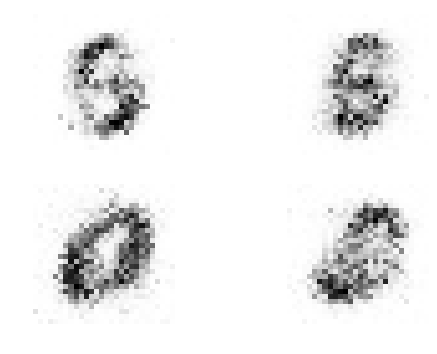

('iteration: ', 4400)


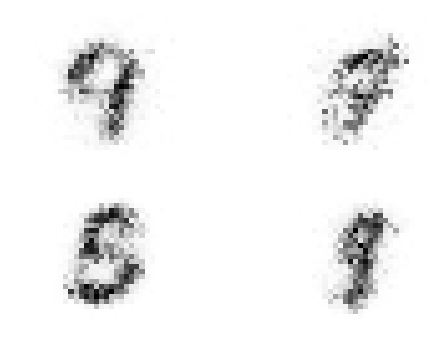

('iteration: ', 4600)


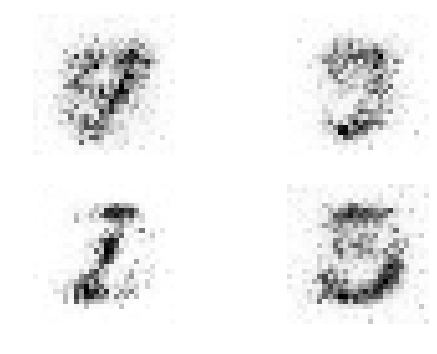

('iteration: ', 4800)


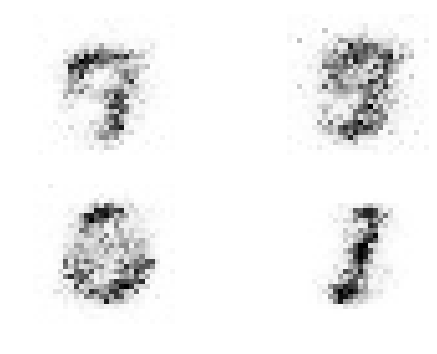

('iteration: ', 5000)


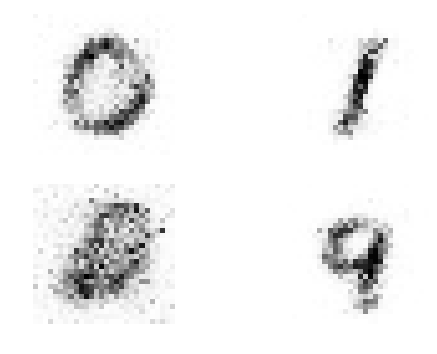

('iteration: ', 5200)


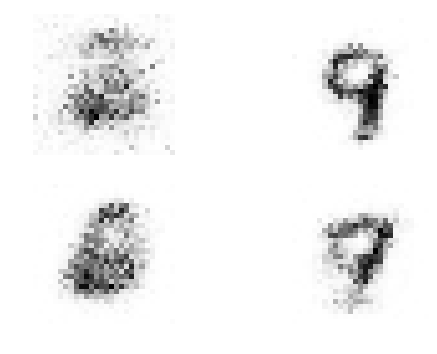

('iteration: ', 5400)


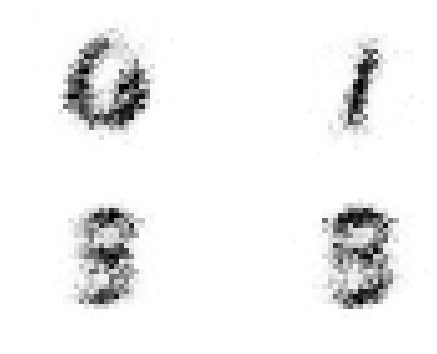

('iteration: ', 5600)


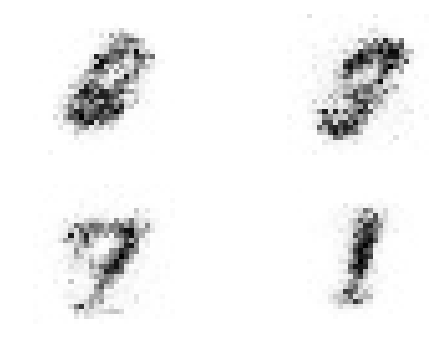

('iteration: ', 5800)


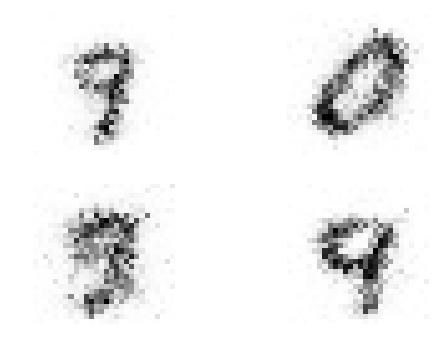

('iteration: ', 6000)


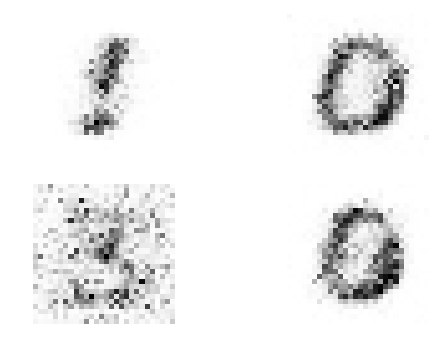

('iteration: ', 6200)


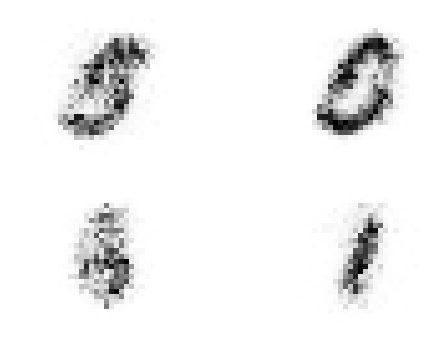

('iteration: ', 6400)


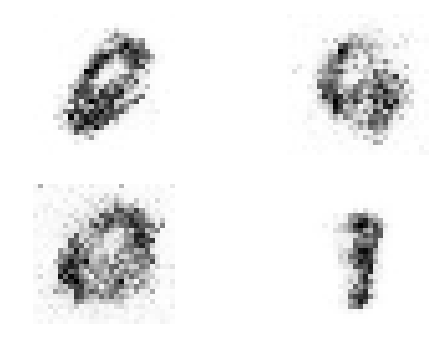

('iteration: ', 6600)


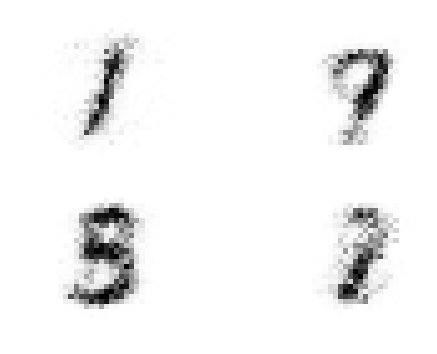

('iteration: ', 6800)


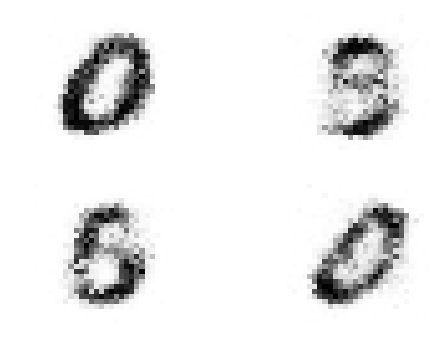

('iteration: ', 7000)


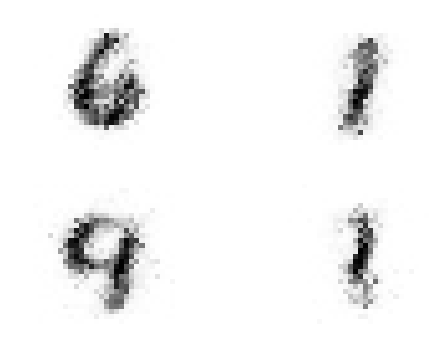

('iteration: ', 7200)


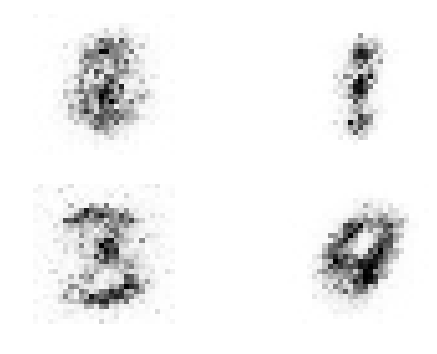

('iteration: ', 7400)


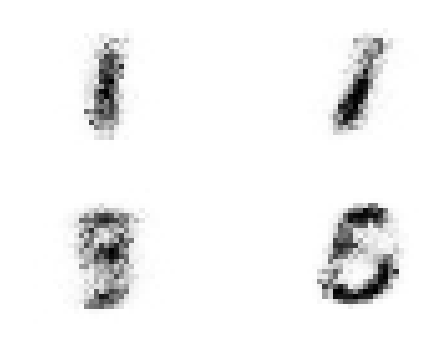

('iteration: ', 7600)


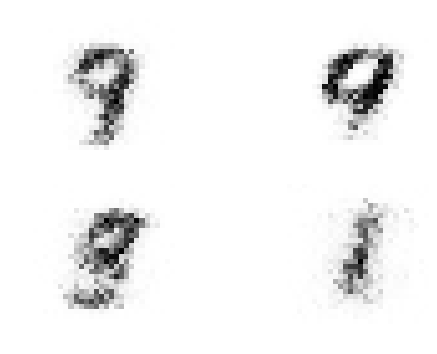

('iteration: ', 7800)


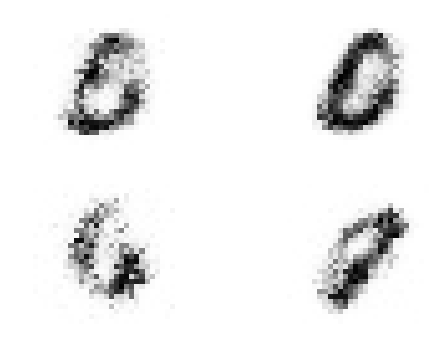

('iteration: ', 8000)


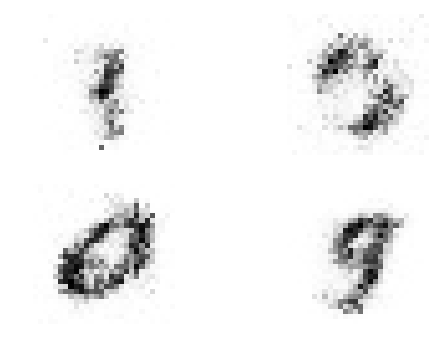

('iteration: ', 8200)


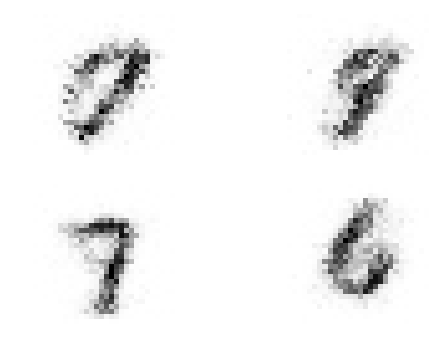

('iteration: ', 8400)


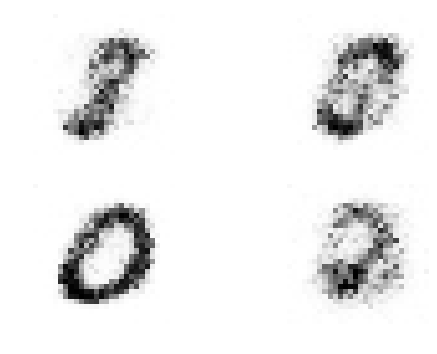

('iteration: ', 8600)


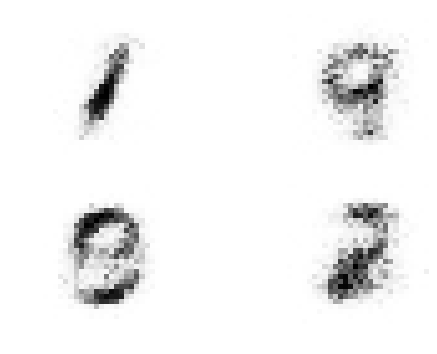

('iteration: ', 8800)


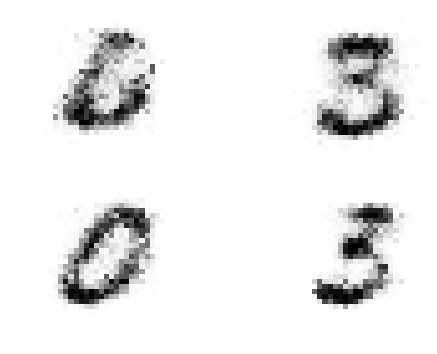

('iteration: ', 9000)


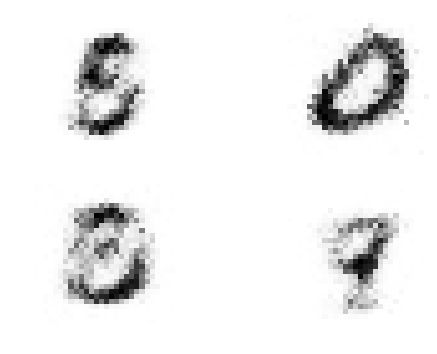

('iteration: ', 9200)


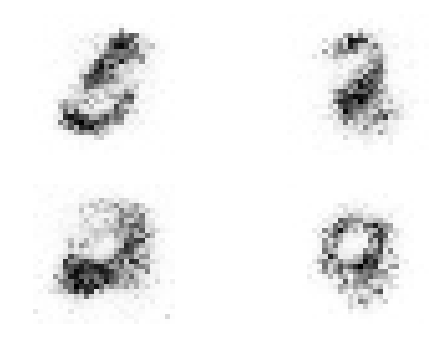

('iteration: ', 9400)


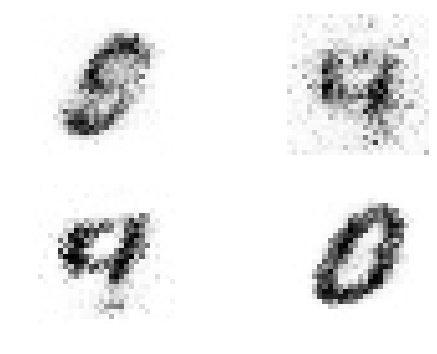

('iteration: ', 9600)


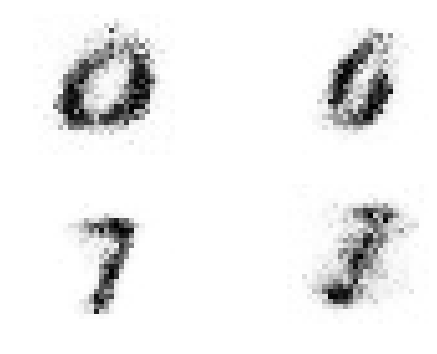

('iteration: ', 9800)


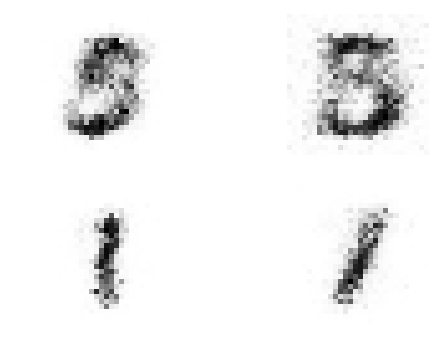

('iteration: ', 10000)


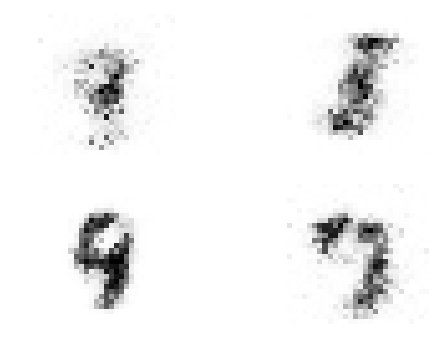

('iteration: ', 10200)


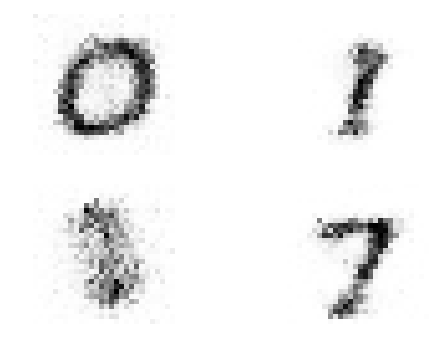

('iteration: ', 10400)


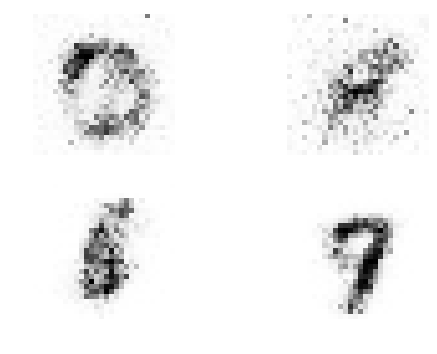

('iteration: ', 10600)


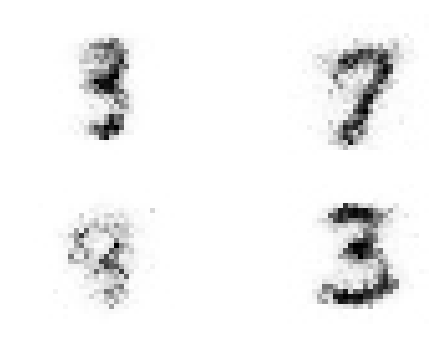

('iteration: ', 10800)


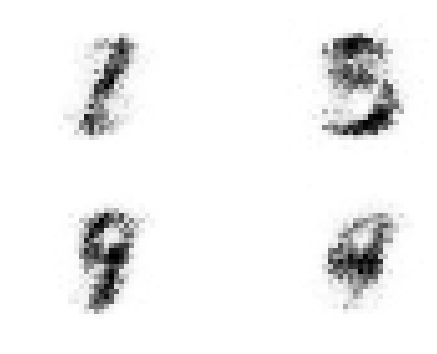

('iteration: ', 11000)


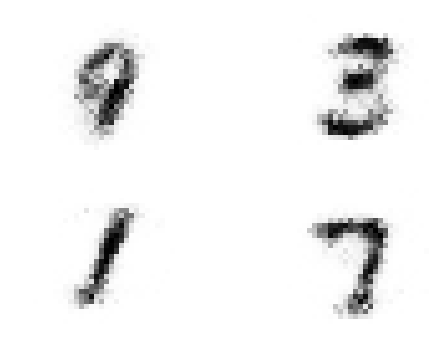

('iteration: ', 11200)


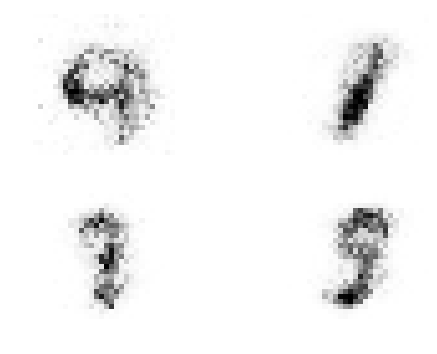

('iteration: ', 11400)


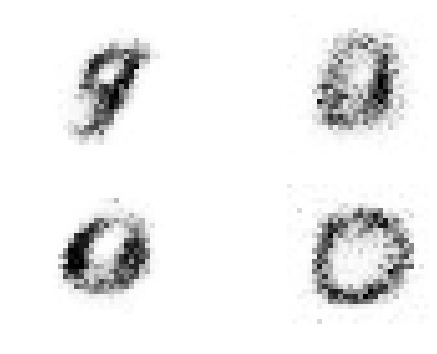

('iteration: ', 11600)


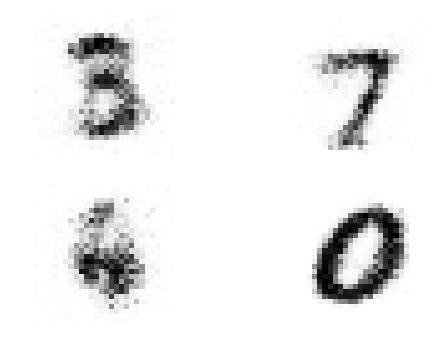

('iteration: ', 11800)


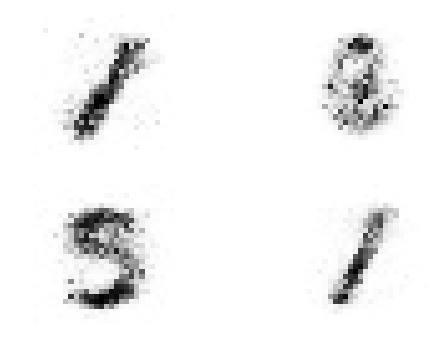

('iteration: ', 12000)


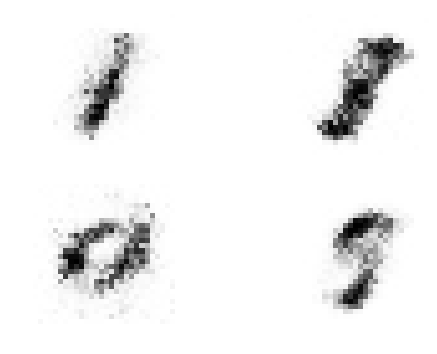

('iteration: ', 12200)


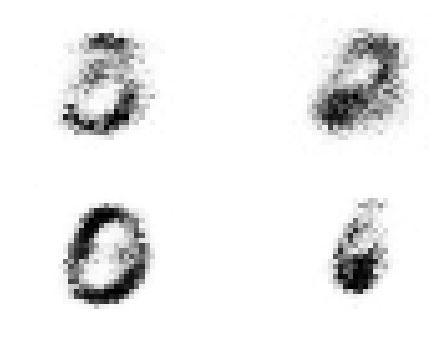

('iteration: ', 12400)


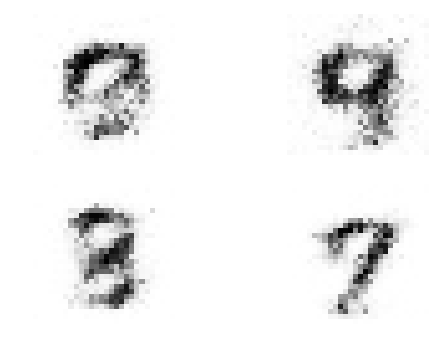

('iteration: ', 12600)


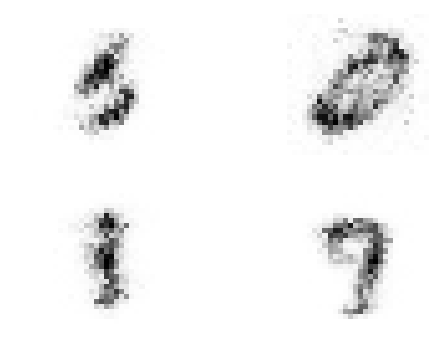

('iteration: ', 12800)


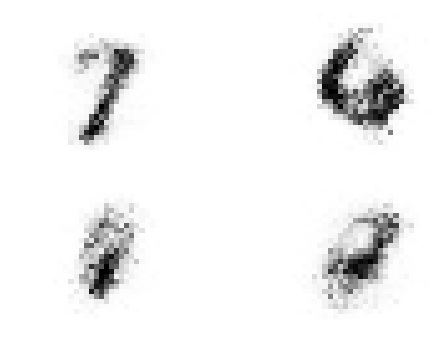

('iteration: ', 13000)


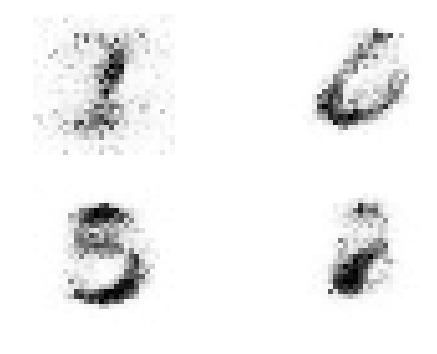

('iteration: ', 13200)


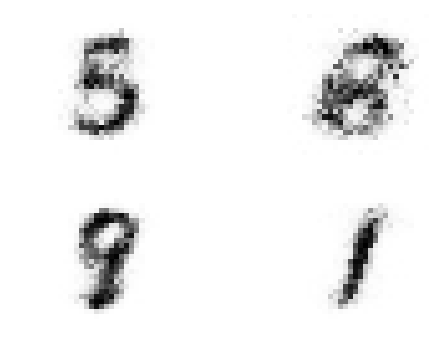

('iteration: ', 13400)


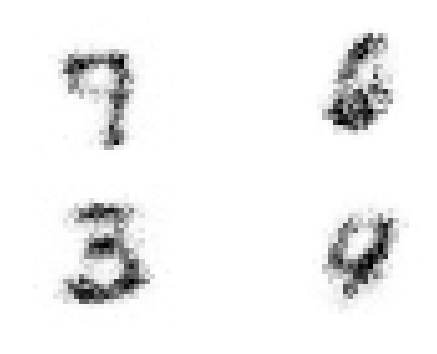

('iteration: ', 13600)


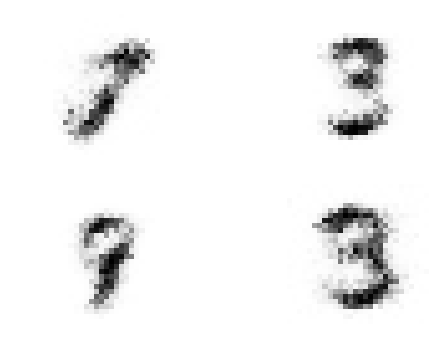

('iteration: ', 13800)


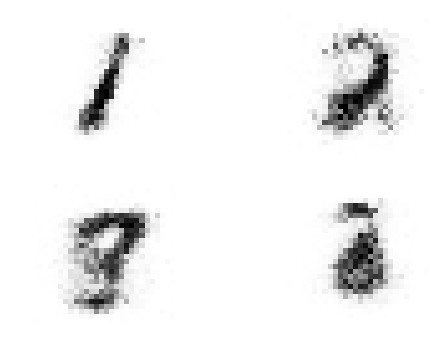

('iteration: ', 14000)


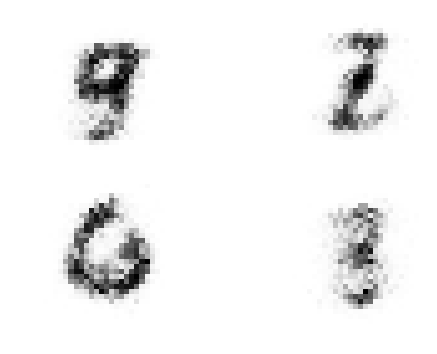

('iteration: ', 14200)


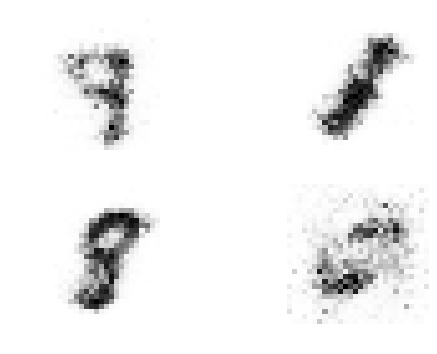

('iteration: ', 14400)


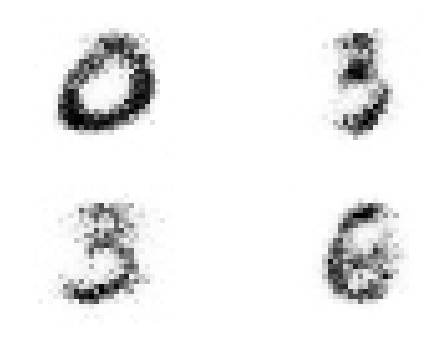

('iteration: ', 14600)


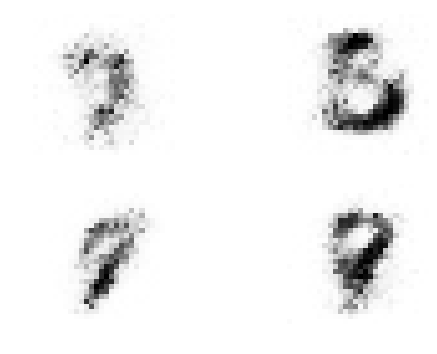

('iteration: ', 14800)


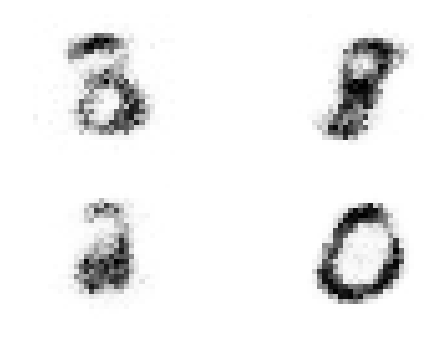

('iteration: ', 15000)


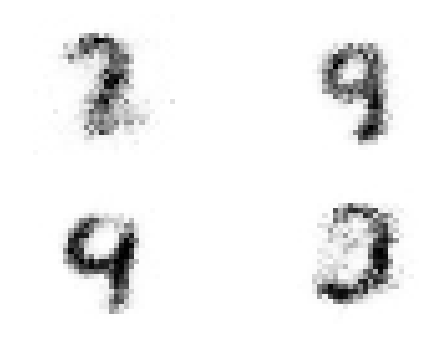

('iteration: ', 15200)


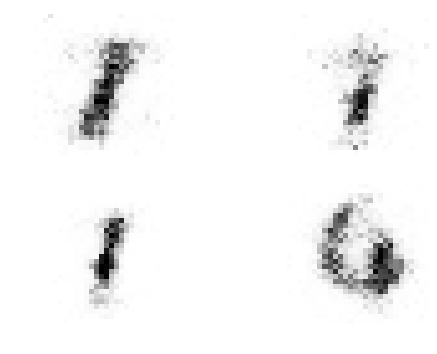

('iteration: ', 15400)


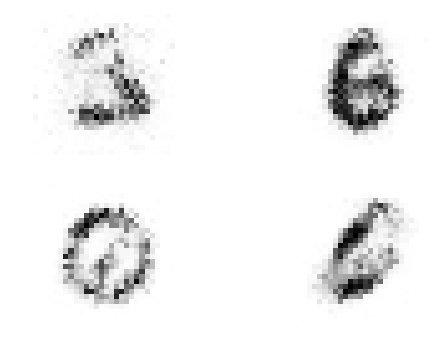

('iteration: ', 15600)


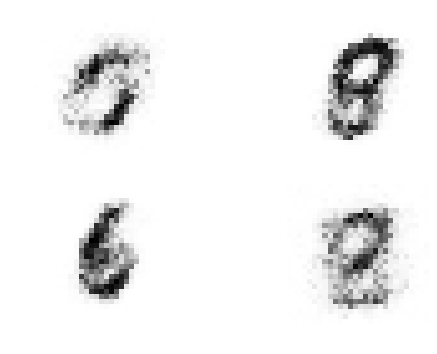

('iteration: ', 15800)


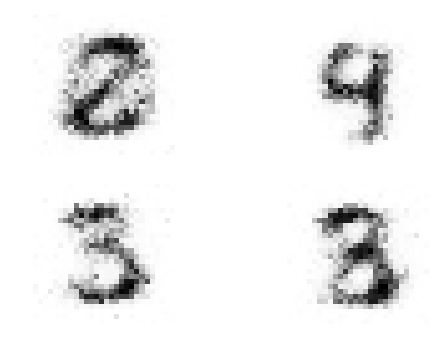

('iteration: ', 16000)


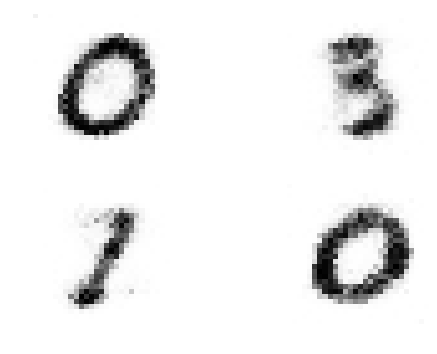

('iteration: ', 16200)


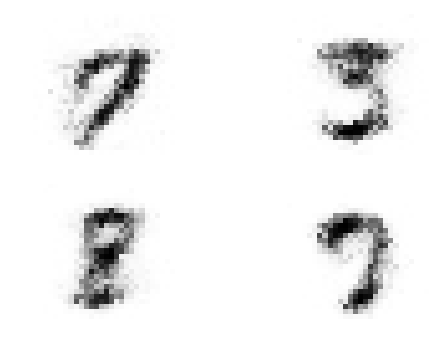

('iteration: ', 16400)


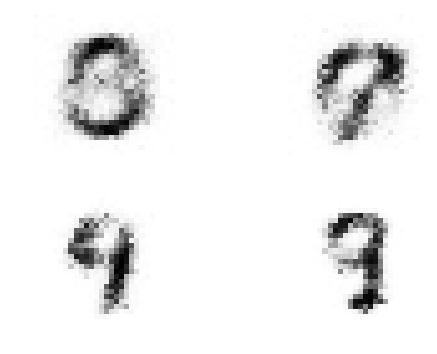

('iteration: ', 16600)


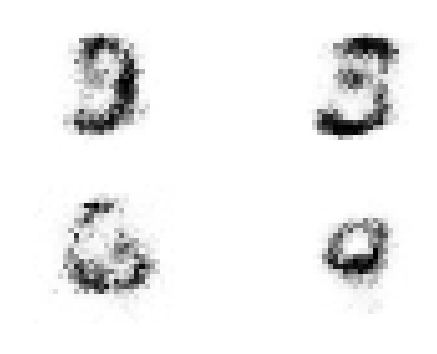

('iteration: ', 16800)


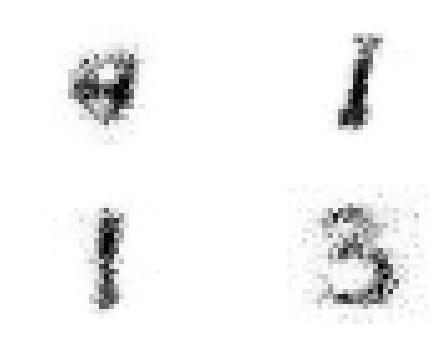

('iteration: ', 17000)


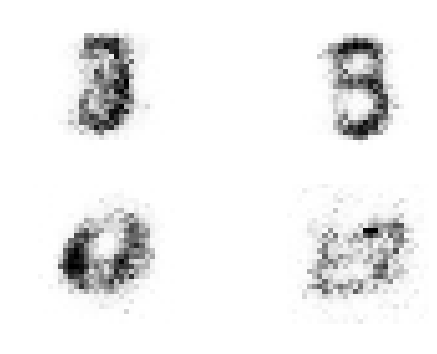

('iteration: ', 17200)


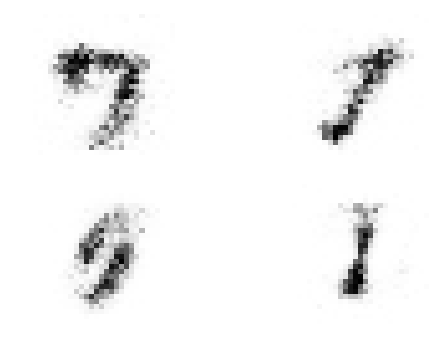

('iteration: ', 17400)


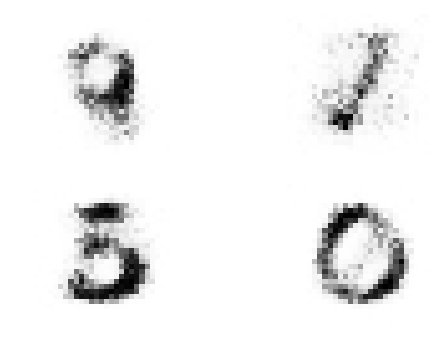

('iteration: ', 17600)


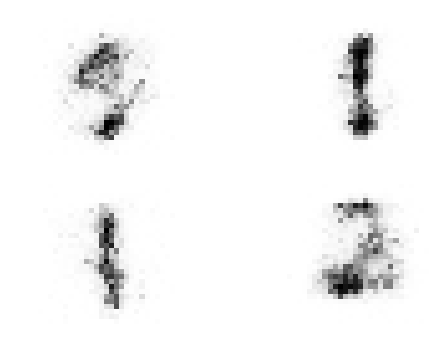

('iteration: ', 17800)


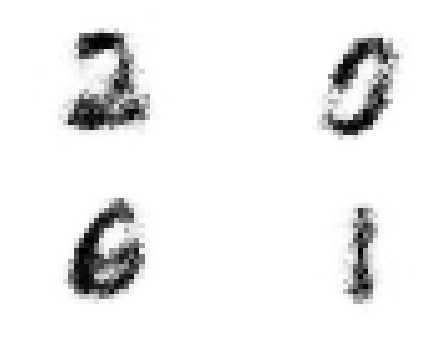

('iteration: ', 18000)


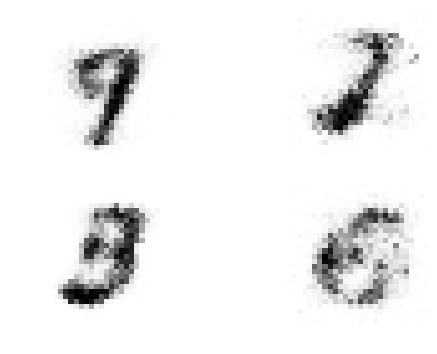

('iteration: ', 18200)


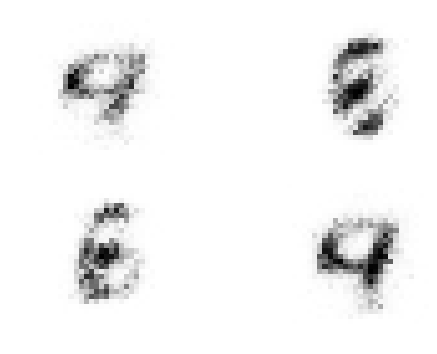

('iteration: ', 18400)


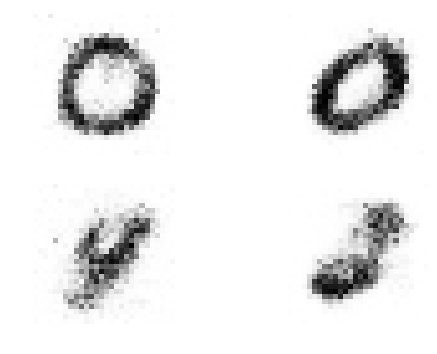

('iteration: ', 18600)


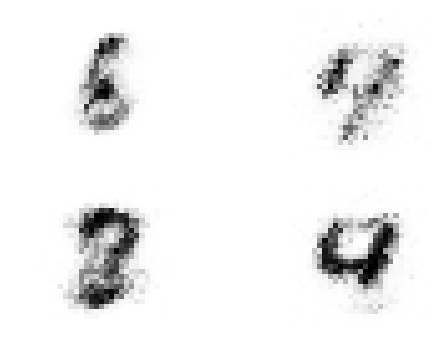

('iteration: ', 18800)


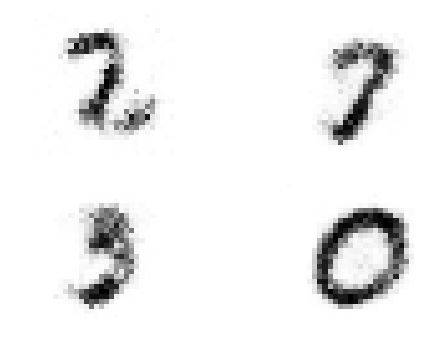

('iteration: ', 19000)


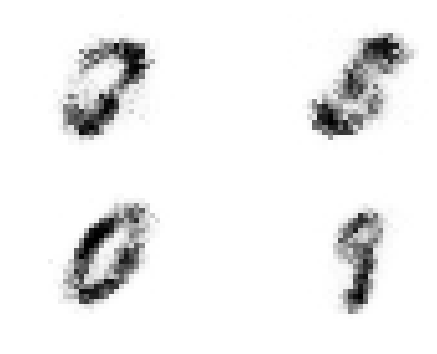

('iteration: ', 19200)


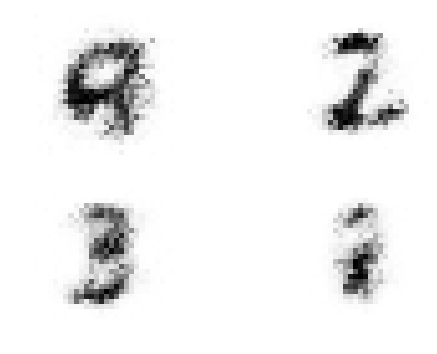

('iteration: ', 19400)


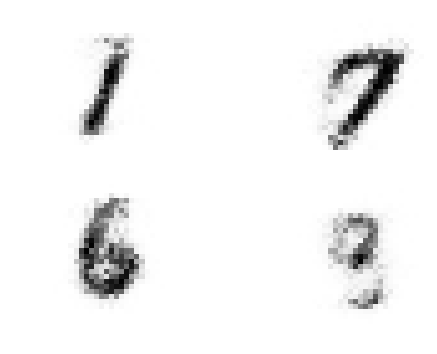

('iteration: ', 19600)


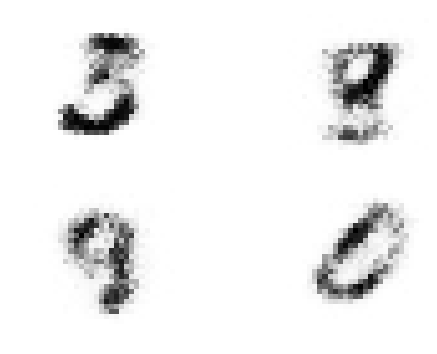

('iteration: ', 19800)


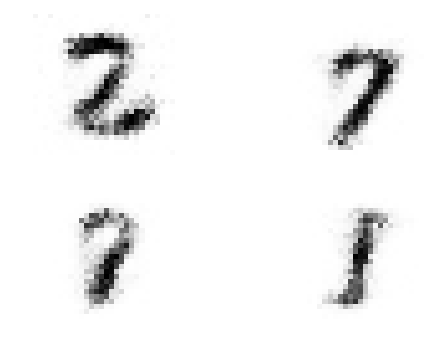

In [52]:
losses =run(20000,0.0001)

<function matplotlib.pyplot.show>

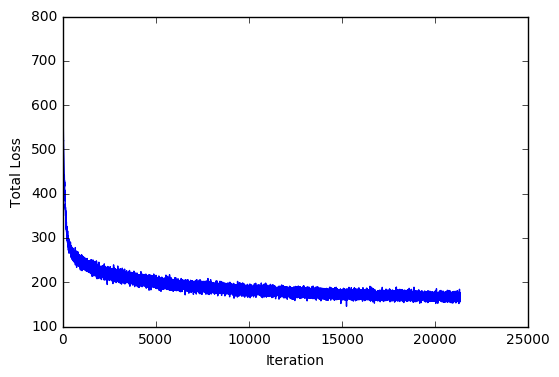

In [53]:
## Plot of Loss function
plt.plot(losses[1:])
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.show

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?

In [28]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## Set number of samples and number of X variables
N_samples, X_dim = mnist_images.shape 
## Mini batch size
mb_size = 100
## Fix dimensionality of latent variables (output layer)
Z_dim = 2
## Dimensionality of the hidden layer
h_dim = 128 
## Learning rate for stochastic gradient descent
lr = 1e-3

## Initialize parameters of the encoder
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## Initialize parameter of the decoder
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## Initilization for the run and run (controller) function
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)
losses = [10**10]


def run_ndim(num_iter,conv_check):
    conv=False
    
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## Forward propagate through network
        ## Encode X using Q network, sample using reparameterization trick, decode sample Z with P network
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)
        X_sample = P(z)
      
        ## Compute Loss of decoding, cross entropy between decoded data and input data
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## Compute KL divergence between Q(Z|X)= N(z|mu,sig) and P(Z) = N(0,1)
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        
        ## Compute total loss and evaluate convergence
        loss = recon_loss + kl_loss
        losses.append(loss.data.numpy()[0])
        if abs(losses[-1] - losses[-2]) < conv_check:
            conv = True
            break
        
        ## Backpropagation error towards input layer (and afterwards update weights in solver.step)
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()
        if(iter % 500 == 0):
            print iter
        
        ## Now weights are updated for the mini batch and a new mini batch is chosen for num_iter
    z_M,z_S = Q(X)
    return losses, z_M,z_S, conv

In [29]:
losses, z_mu,z_vars, conv = run_ndim(10000,0.001)
conv

0
500
1000
1500
2000
2500


**Answer: ** Kingma's manifold includes all nubers between 0 and 9 whereas our manifold includes fewer recognizable numbers (in particular one can clearly see 0, 9, 1, and 7 and less clearly 5 and 6) as well as noise in the upper left corner. We tried plotting different sections of the linear coordinate grid (see A and B parameters below) and chose a section showing most numbers and least noise. Reasons for differences may include: Kingma transformed the linear coordinate grid using the CDF of a Gaussian before popagating it through P, and we also usd a rather rough convergence criterium and it is to be expected that Kingma trained the model to higher degree of sophistication.

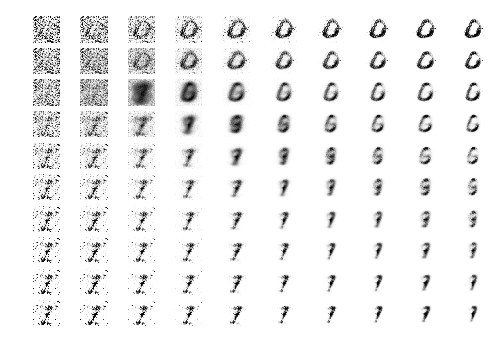

In [47]:
A = linspace(-2,8,10,dtype=float)
z1 = A.repeat(10,0).flatten().reshape(1,100)
B = linspace(-5,5,10,dtype=float)
z2 = B.repeat(10).reshape(1,100)
z3 = np.concatenate((z1,z2), axis=0)
#z_M,z_S = Q(Z_lin)
#z = sample_z(z_mu, z_vars)
#X_sample = P(Z_lin)

#print z.size()
#lin_M, lin_S = Q(linspace(-5,5,10))

zz = np.transpose(z1.reshape(10,10)).flatten().reshape(1,100)
#z1.shape
Z_lin = np.concatenate((z1,zz), axis=0)
#Z_lin= Variable(torch.from_numpy(np.transpose(Z_lin)))
Z_lin= Variable(torch.FloatTensor(np.transpose(Z_lin)))

D = P(Z_lin)

D.size()
D2 = D.data.numpy()
plot_digits(D2,10)

**Reprodution of Figure 5 in Kingma (for 2D space):**

torch.Size([100, 2])


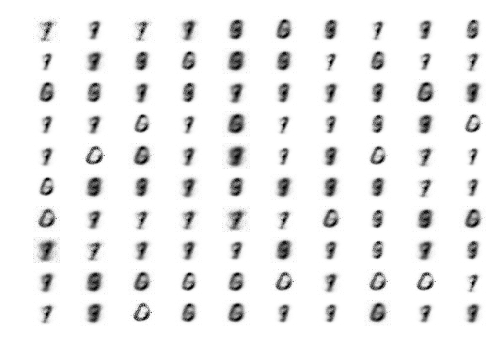

In [48]:
samples         = sample_z(z_mu,z_vars)
print samples.size()
decoded_samples_batch = P(samples)
decoded_samples_batch.size()

plot_sam =decoded_samples_batch
plot_sam2 = plot_sam.data.numpy()
plot_digits(plot_sam2,10)